In [1]:
import shutil
import os
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

from PIL import Image

from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

In [2]:
def load_data_to_df(path):
    imgs = []
    paths = []
    breed  = []
    height, width = [], []

    for folder in tqdm(glob(path)):
        img = cv2.imread(folder)
        imgs.append(img)
        paths.append(folder)
        height.append(img.shape[0])
        width.append(img.shape[1])
        breed.append(folder.split("/")[3].split("-", 1)[1])
    df = pd.DataFrame({'img' : imgs, 'path': paths, 'breed': breed, 'height': height, 'width': width})
    return df

In [3]:
df = load_data_to_df("../dataset/Images/*/*")
df['breed'] = df['breed'].str.lower().str.replace("_", " ")

  0%|          | 0/20580 [00:00<?, ?it/s]

In [4]:
#TODO
mean_std = datasets.ImageFolder(root = "../42_split/train",# loader=,
                                transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in tqdm(mean_std):
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(mean_std)
stds /= len(mean_std)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

  0%|          | 0/14817 [00:00<?, ?it/s]

Calculated means: tensor([0.4765, 0.4523, 0.3909])
Calculated stds: tensor([0.2335, 0.2287, 0.2271])


In [5]:
SEED = 42
def split_df(df, rs=SEED):
    Xy = df[["path", "breed"]]
    train, test = train_test_split(
        Xy, test_size=0.2, random_state=rs, stratify=df['breed'])
    train, valid = train_test_split(
        train, test_size=0.1, random_state=rs, stratify=train['breed'])
    return train, test, valid

In [6]:
train, test, valid = split_df(df)

In [7]:
class_map = {key:id for id, key in enumerate(df["breed"].unique())}

class CatsVsDogsDataset(Dataset):
    def __init__(self, ds, class_map=class_map, transform=None):
        self.images_filepaths = ds["path"].to_list()
        self.label = ds["breed"].to_list()
        self.label_map = class_map
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        class_id = self.label_map[self.label[idx]]
        class_id = torch.tensor(class_id)

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, class_id

In [8]:
train_transform = A.Compose(

    [     A.Resize(width=32, height=32),
          # A.RandomCrop(width=30, height=30),
          A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.1),
          A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
          A.OneOf([
              A.Blur(blur_limit=3, p=0.5),
              A.ColorJitter(p=0.5),
          ], p=1.0),
          A.Normalize(
              mean=means,
              std=stds,
              max_pixel_value=255,
          ),
          ToTensorV2(),
          ]

)

test_transform = A.Compose(
    [
        A.Resize(width=32, height=32),
        # A.SmallestMaxSize(max_size=160),
        # A.CenterCrop(height=128, width=128),
        A.Normalize(mean=means, std=stds),
        ToTensorV2(),
    ]
)


In [9]:
train_dataset = CatsVsDogsDataset(ds=train, transform=train_transform)
val_dataset = CatsVsDogsDataset(ds=valid, transform=test_transform)
test_dataset = CatsVsDogsDataset(ds=test, transform=test_transform)

In [10]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": 4,
    "epochs": 10,
}

In [11]:
train_loader = data.DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)

test_loader = data.DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = data.DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [12]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes=120):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [13]:
device = params["device"]
net = ConvNeuralNet()
net.to(params["device"])
criterion = nn.CrossEntropyLoss()
# also the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9)

In [17]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(1, 40):  # loop over the dataset multiple times

    running_loss = .0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # get the inputs
        # inputs, labels = data
        # if device == 'cuda':
        inputs, labels = images.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)

    if epoch % 4 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))

    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with torch.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for inf in test_loader:
            inputs, labels = inf
            # if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)

        if epoch % 4 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')


Epoch: 4
Train Acc. => 11.669% | Train Loss => 3.90054
Test Acc.  => 9.208% | Test Loss  => 4.14947

Epoch: 8
Train Acc. => 12.735% | Train Loss => 3.85822
Test Acc.  => 9.524% | Test Loss  => 4.14017

Epoch: 12
Train Acc. => 13.221% | Train Loss => 3.82463
Test Acc.  => 9.475% | Test Loss  => 4.16348

Epoch: 16
Train Acc. => 13.721% | Train Loss => 3.78833
Test Acc.  => 9.888% | Test Loss  => 4.16431

Epoch: 20
Train Acc. => 14.578% | Train Loss => 3.74137
Test Acc.  => 10.204% | Test Loss  => 4.17929

Epoch: 24
Train Acc. => 15.421% | Train Loss => 3.70550
Test Acc.  => 10.228% | Test Loss  => 4.22703

Epoch: 28
Train Acc. => 15.631% | Train Loss => 3.67384
Test Acc.  => 10.690% | Test Loss  => 4.21317

Epoch: 32
Train Acc. => 16.474% | Train Loss => 3.64893
Test Acc.  => 9.815% | Test Loss  => 4.20095

Epoch: 36
Train Acc. => 16.758% | Train Loss => 3.61373
Test Acc.  => 10.107% | Test Loss  => 4.27633
Finished Training


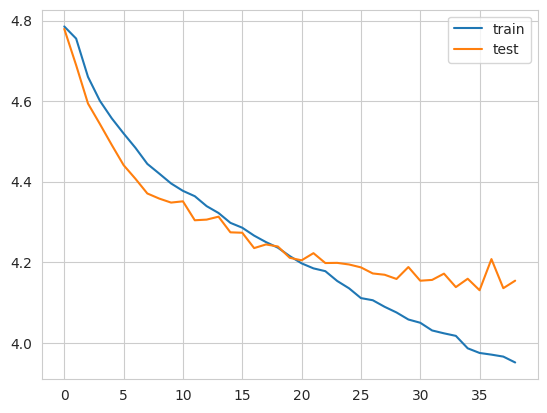

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

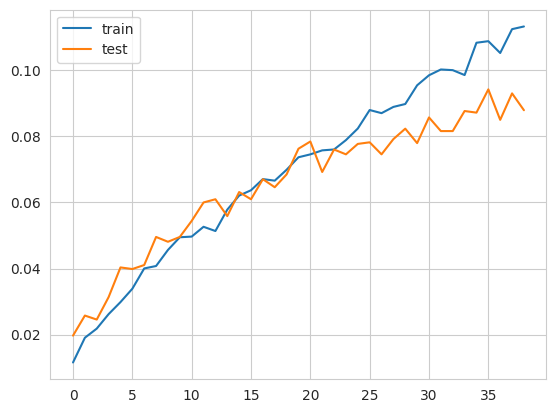

In [16]:
plt.show()
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()